#  SPE DSEATS Africa Datathon 2025 - Well Classification

This notebook classifies 20 oil wells and estimates total oil production per reservoir using provided datasets.

## Objective
- Classify 20 wells by:
  - Reservoir Name
  - Reservoir Type (Saturated/Undersaturated)
  - Well Type (NF/GL)
  - Production Type (Steady/Unsteady)
  - GOR Trend (aSolGOR/bSolGOR/Combo)
  - Watercut Trend (Flat/Incr/Decr/Combo)
  - Oil PI Trend (Flat/Incr/Decr/Combo)
- Estimate total oil production (reservoir barrels) for five reservoirs (ACHI, KEMA, MAKO, DEPU, JANI)

## Workflow

-  Project Introduction & Objective
-  Import Libraries & Load Data
-  Data Cleaning & Preprocessing
-  Exploratory Data Analysis (EDA)
-  Feature Engineering (Watercut, GOR, PI)
-  Classify Wells Using Logic Rules
-  (Optional) Automate with ML Models
-  Export Classification File & Prepare Slides

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visual theme
sns.set_style("darkgrid")  
sns.set_palette("Set2")

In [20]:
# Load datasets
well_df = pd.read_csv("C:/Users/osuol/Desktop/SPE DSEAT/spe_africa_dseats_datathon_2025_wells_dataset.csv")
reservoir_df = pd.read_csv("C:/Users/osuol/Desktop/SPE DSEAT/reservoir_info.csv")

# Display shape and columns
well_df.head()

,PROD_DATE,WELL_NAME,ON_STREAM_HRS,BOTTOMHOLE_FLOWING_PRESSURE (PSI),DOWNHOLE_TEMPERATURE (deg F),ANNULUS_PRESS (PSI),CHOKE_SIZE (%),WELL_HEAD_PRESSURE (PSI),WELL_HEAD_TEMPERATURE (deg F),CUMULATIVE_OIL_PROD (STB),CUMULATIVE_FORMATION_GAS_PROD (MSCF),CUMULATIVE_TOTAL_GAS_PROD (MSCF),CUMULATIVE_WATER_PROD (BBL)
0,15-Feb-14,Well_#1,0.0,"4,050",189.866,0,1.17951,482.46,50.864,0,0,0,0
1,16-Feb-14,Well_#1,0.0,"3,961",189.945,0,2.99440,328.601,47.668,0,0,0,0
2,17-Feb-14,Well_#1,0.0,"3,961",190.004,0,1.90349,387.218,48.962,0,0,0,0
3,18-Feb-14,Well_#1,0.0,"3,964",190.020,0,0.00000,308.98,46.636,0,0,0,0
4,19-Feb-14,Well_#1,0.0,"3,965",190.107,0,30.20760,196.057,47.297,0,0,0,0


In [9]:
well_df.shape

(7955, 13)

In [13]:
well_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7955 entries, 0 to 7954
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   PROD_DATE                             7955 non-null   object 
 1   WELL_NAME                             7955 non-null   object 
 2   ON_STREAM_HRS                         7955 non-null   float64
 3   BOTTOMHOLE_FLOWING_PRESSURE (PSI)     7955 non-null   object 
 4   DOWNHOLE_TEMPERATURE (deg F)          7955 non-null   float64
 5   ANNULUS_PRESS (PSI)                   7955 non-null   object 
 6   CHOKE_SIZE (%)                        7955 non-null   float64
 7   WELL_HEAD_PRESSURE (PSI)              7955 non-null   object 
 8   WELL_HEAD_TEMPERATURE (deg F)         7955 non-null   float64
 9   CUMULATIVE_OIL_PROD (STB)             7955 non-null   object 
 10  CUMULATIVE_FORMATION_GAS_PROD (MSCF)  7955 non-null   object 
 11  CUMULATIVE_TOTAL_

In [11]:
reservoir_df

,Reservoir Name,Initial Reservoir Pressure (PSI),Bubble Point Pressure (PSI),Current Average Reservoir Pressure (PSI),Solution Gas-Oil-Ratio (SCF/BBL),Formation Volume Factor (RB/STB)
0,ACHI,"3,500","3,300","2,700",800,1.20
1,KEMA,"4,200","4,000","3,900",600,1.45
2,MAKO,"3,500","3,500","3,000",500,1.15
3,DEPU,"2,800","2,800","2,400","1,200",1.37
4,JANI,"4,500","4,300","4,200","1,000",1.30


I noticed that some columns with numbers like pressures and production volumes are showing as `object` instead of numeric. This is likely because of comma separators.

I'll fix that by removing the commas and convert them to float so I can work with them properly later on.

In [26]:
# Convert PROD_DATE to datetime
well_df['PROD_DATE'] = pd.to_datetime(well_df['PROD_DATE'], format='%d-%b-%y')

In [27]:
# Removing commas,and converting to float
cols_to_clean = [ 'BOTTOMHOLE_FLOWING_PRESSURE (PSI)',  'ANNULUS_PRESS (PSI)',  'WELL_HEAD_PRESSURE (PSI)', 'CUMULATIVE_OIL_PROD (STB)', 'CUMULATIVE_FORMATION_GAS_PROD (MSCF)', 'CUMULATIVE_WATER_PROD (BBL)']
for col in cols_to_clean:
    well_df[col] = well_df[col].astype(str).str.replace(",", "").astype(float)

well_df.info()
well_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7955 entries, 0 to 7954
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   PROD_DATE                             7955 non-null   datetime64[ns]
 1   WELL_NAME                             7955 non-null   object        
 2   ON_STREAM_HRS                         7955 non-null   float64       
 3   BOTTOMHOLE_FLOWING_PRESSURE (PSI)     7955 non-null   float64       
 4   DOWNHOLE_TEMPERATURE (deg F)          7955 non-null   float64       
 5   ANNULUS_PRESS (PSI)                   7955 non-null   float64       
 6   CHOKE_SIZE (%)                        7955 non-null   float64       
 7   WELL_HEAD_PRESSURE (PSI)              7955 non-null   float64       
 8   WELL_HEAD_TEMPERATURE (deg F)         7955 non-null   float64       
 9   CUMULATIVE_OIL_PROD (STB)             7955 non-null   float64       
 10  

,PROD_DATE,WELL_NAME,ON_STREAM_HRS,BOTTOMHOLE_FLOWING_PRESSURE (PSI),DOWNHOLE_TEMPERATURE (deg F),ANNULUS_PRESS (PSI),CHOKE_SIZE (%),WELL_HEAD_PRESSURE (PSI),WELL_HEAD_TEMPERATURE (deg F),CUMULATIVE_OIL_PROD (STB),CUMULATIVE_FORMATION_GAS_PROD (MSCF),CUMULATIVE_TOTAL_GAS_PROD (MSCF),CUMULATIVE_WATER_PROD (BBL)
0,2014-02-15,Well_#1,0.0,4050.0,189.866,0.0,1.17951,482.460,50.864,0.0,0.0,0,0.0
1,2014-02-16,Well_#1,0.0,3961.0,189.945,0.0,2.99440,328.601,47.668,0.0,0.0,0,0.0
2,2014-02-17,Well_#1,0.0,3961.0,190.004,0.0,1.90349,387.218,48.962,0.0,0.0,0,0.0
3,2014-02-18,Well_#1,0.0,3964.0,190.020,0.0,0.00000,308.980,46.636,0.0,0.0,0,0.0
4,2014-02-19,Well_#1,0.0,3965.0,190.107,0.0,30.20760,196.057,47.297,0.0,0.0,0,0.0


In [22]:
# Clean reservoir_df columns
res_cols_to_clean = [
    'Initial Reservoir Pressure (PSI)',
    'Bubble Point Pressure (PSI)',
    'Current Average Reservoir Pressure (PSI)',
    'Solution Gas-Oil-Ratio (SCF/BBL)',
    'Formation Volume Factor (RB/STB)'
]
for col in res_cols_to_clean:
    reservoir_df[col] = reservoir_df[col].astype(str).str.replace(",", "").astype(float)


In [23]:
reservoir_df

,Reservoir Name,Initial Reservoir Pressure (PSI),Bubble Point Pressure (PSI),Current Average Reservoir Pressure (PSI),Solution Gas-Oil-Ratio (SCF/BBL),Formation Volume Factor (RB/STB)
0,ACHI,3500.0,3300.0,2700.0,800.0,1.20
1,KEMA,4200.0,4000.0,3900.0,600.0,1.45
2,MAKO,3500.0,3500.0,3000.0,500.0,1.15
3,DEPU,2800.0,2800.0,2400.0,1200.0,1.37
4,JANI,4500.0,4300.0,4200.0,1000.0,1.30


Some of the numeric columns were showing as `object` because of commas in the values.  
I've cleaned the numbers and also changed the production date to datetime format so they’re now usable for analysis. 

### PREPROCESSING

In [31]:
# Filtering out non-production rows (ON_STREAM_HRS > 0)
well_df = well_df[well_df['ON_STREAM_HRS'] > 0]

In [33]:
# Calculating daily production rates
well_df['OIL_RATE'] = well_df['CUMULATIVE_OIL_PROD (STB)'].diff() / well_df['ON_STREAM_HRS']
well_df['GAS_RATE'] = well_df['CUMULATIVE_FORMATION_GAS_PROD (MSCF)'].diff() / well_df['ON_STREAM_HRS']
well_df['WATER_RATE'] = well_df['CUMULATIVE_WATER_PROD (BBL)'].diff() / well_df['ON_STREAM_HRS']

In [34]:
# Dropping rows with NaN values from diff() and handling negative rates (anomalies)
well_df = well_df.dropna()
well_df = well_df[(well_df['OIL_RATE'] >= 0) & (well_df['GAS_RATE'] >= 0) & (well_df['WATER_RATE'] >= 0)]

In [41]:
# Checking for missing values
print("Missing Values After Preprocessing:")
print(well_df.isna().sum())

Missing Values After Preprocessing:
PROD_DATE                               0
WELL_NAME                               0
ON_STREAM_HRS                           0
BOTTOMHOLE_FLOWING_PRESSURE (PSI)       0
DOWNHOLE_TEMPERATURE (deg F)            0
ANNULUS_PRESS (PSI)                     0
CHOKE_SIZE (%)                          0
WELL_HEAD_PRESSURE (PSI)                0
WELL_HEAD_TEMPERATURE (deg F)           0
CUMULATIVE_OIL_PROD (STB)               0
CUMULATIVE_FORMATION_GAS_PROD (MSCF)    0
CUMULATIVE_TOTAL_GAS_PROD (MSCF)        0
CUMULATIVE_WATER_PROD (BBL)             0
OIL_RATE                                0
GAS_RATE                                0
WATER_RATE                              0
dtype: int64


In [40]:
# Handling zero or negative pressures (assume invalid if <= 0)
well_df = well_df[well_df['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'] > 0]
well_df = well_df[well_df['WELL_HEAD_PRESSURE (PSI)'] > 0]

In [44]:
print("\nSummary Statistics of Cleaned Data:")
print(well_df.describe())


Summary Statistics of Cleaned Data:
                           PROD_DATE  ON_STREAM_HRS  \
count                           7355    7355.000000   
mean   2013-09-14 07:50:51.801495552      23.186016   
min              2011-02-18 00:00:00       0.250000   
25%              2012-08-14 00:00:00      24.000000   
50%              2013-07-27 00:00:00      24.000000   
75%              2014-10-22 00:00:00      24.000000   
max              2016-08-12 00:00:00      25.000000   
std                              NaN       3.196613   

       BOTTOMHOLE_FLOWING_PRESSURE (PSI)  DOWNHOLE_TEMPERATURE (deg F)  \
count                        7355.000000                   7355.000000   
mean                         2597.089191                    169.468232   
min                           436.000000                     31.440000   
25%                          2178.000000                    150.408500   
50%                          2454.000000                    158.494000   
75%                    

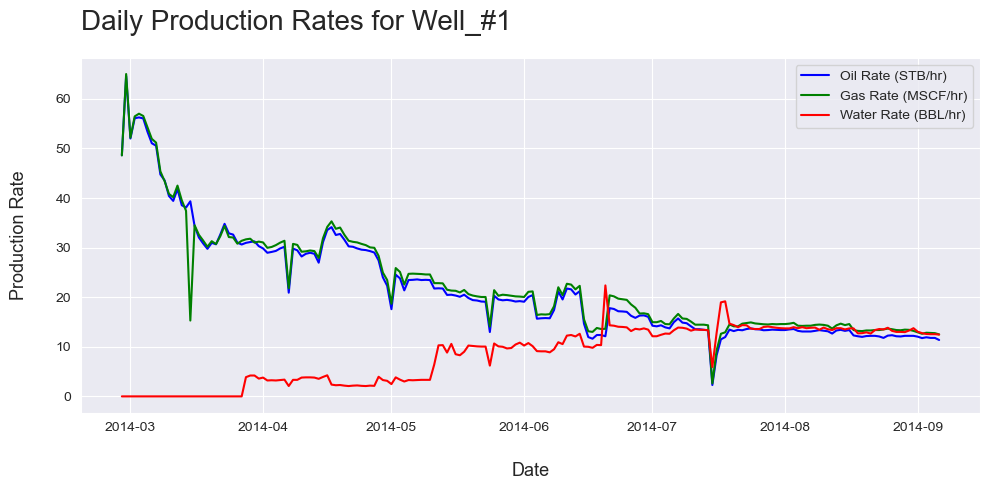

In [43]:
# Visualizing daily production rates for a sample well (e.g., Well_#1)
sample_well = 'Well_#1'
well_data = well_df[well_df['WELL_NAME'] == sample_well]
plt.figure(figsize=(10, 5))
plt.plot(well_data['PROD_DATE'], well_data['OIL_RATE'], label='Oil Rate (STB/hr)', color='blue')
plt.plot(well_data['PROD_DATE'], well_data['GAS_RATE'], label='Gas Rate (MSCF/hr)', color='green')
plt.plot(well_data['PROD_DATE'], well_data['WATER_RATE'], label='Water Rate (BBL/hr)', color='red')
plt.xlabel("Date", fontsize=13, labelpad=20)
plt.ylabel("Production Rate", fontsize=13, labelpad=20)
plt.title(f"Daily Production Rates for {sample_well}", fontsize=20, pad=20, loc="left")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('daily_production_well_1.png', dpi=300)
plt.show()

The plot shows oil rate declining steadily, water rate increasing gradually (suggesting an Increasing watercut trend for classification), and gas rate staying stable.

In [28]:
!git add .

In [29]:
!git commit -m "Cleaned"

[main 81bb61c] Cleaned
 2 files changed, 545 insertions(+), 17355 deletions(-)


In [30]:
!git push origin main

To https://github.com/Connected-Peter/SPE_DSEAT_2025_GTF.git
   bfc17dd..81bb61c  main -> main
